<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

In [328]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import warnings
import itertools
import time

from sklearn.metrics import mean_squared_error, r2_score
import os

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import f_regression
from xgboost import XGBRegressor

**1. Data Loading and preprocessing**

In [13]:
raw_data = pd.read_csv('..\data\my_PJME_MW.csv', index_col=[0], parse_dates=[0])
display(raw_data.head())
print(raw_data.shape)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


(145374, 13)


In [16]:
data_pw = raw_data.resample(rule='W').mean()
data_pw.drop('dayofmonth', axis=1,inplace=True)
data_pw.drop('dayofyear', axis=1,inplace=True)
data_pw.drop('dayofweek', axis=1,inplace=True)
data_pw.drop('hour', axis=1,inplace=True)
data_pw.drop('is_holiday', axis=1,inplace=True)
data_pw.drop('is_prev_holiday', axis=1,inplace=True)
data_pw.drop('is_next_holiday', axis=1,inplace=True)

display(data_pw.head())
print(data_pw.shape)

,PJME_MW,year,month,quarter,weekofyear
Date,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0


(866, 5)


In [17]:
data_pw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PJME_MW     866 non-null    float64
 1   year        866 non-null    float64
 2   month       866 non-null    float64
 3   quarter     866 non-null    float64
 4   weekofyear  866 non-null    float64
dtypes: float64(5)
memory usage: 40.6 KB


In [18]:
# здесь повторяется код из предыдущих занятий - частично -  без EDA

# 1. 2 pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full')
YMW_pca = pca.fit_transform(data_pw.iloc[:,1:])
data_pw['pca1']=YMW_pca[:,0]
data_pw['pca2']=YMW_pca[:,1]

# 2. historical data as features to 52 weeks
p = 53 # based on ACF
for i in range(p):
    data_pw['t'+str(p-i)] = 0
    data_pw['t'+str(p-i)].values[p:] = data_pw['PJME_MW'].values[i:-(p)+i]

# 3. historical data diffs as features to 9 weeks

first_diff =np.array(data_pw.iloc[1:,0].values - data_pw.iloc[:-1,0].values).astype('float32') 
data_pw['diff1'] = 0
data_pw['diff1'] =  data_pw['diff1'].astype('float') 
data_pw['diff1'].values[1:] = first_diff

k = 13 # based on ACF
for i in range(k):
    data_pw['d'+str(k-i)]=0
    data_pw['d'+str(k-i)].values[k:] = data_pw['diff1'].values[i:-(k)+i]

# 4. exp smoothing features
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

for alpha in [0.01, 0.03, 0.04, 0.06, 0.07, 0.08]:
    data_pw[f'exp_{alpha}'] = exponential_smoothing(data_pw['PJME_MW'], alpha)

In [22]:
display(data_pw.head())
print(data_pw.shape)
print(data_pw.columns)

,PJME_MW,year,month,quarter,weekofyear,pca1,pca2,t53,t52,t51,t50,t49,t48,t47,t46,t45,t44,t43,t42,t41,t40,t39,t38,t37,t36,t35,t34,t33,t32,t31,t30,t29,t28,t27,t26,t25,t24,t23,t22,t21,t20,t19,t18,t17,t16,t15,t14,t13,t12,t11,t10,t9,t8,t7,t6,t5,t4,t3,t2,t1,diff1,d13,d12,d11,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1,exp_0.01,exp_0.03,exp_0.04,exp_0.06,exp_0.07,exp_0.08
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,-25.720691,-8.173537,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,-24.746964,-8.159539,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-904.773926,0,0,0,0,0,0,0,0,0,0,0,0,0,32383.113100,32365.017621,32355.969882,32337.874403,32328.826664,32319.778924
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,-23.773237,-8.145542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-34.505951,0,0,0,0,0,0,0,0,0,0,0,0,0,32373.810778,32337.653521,32319.846325,32284.774796,32267.510464,32250.427087
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,-22.799510,-8.131544,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1311.351196,0,0,0,0,0,0,0,0,0,0,0,0,0,32351.487968,32271.769808,32232.713662,32156.180094,32118.691815,32081.715301
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,-21.732911,-8.116240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-945.041687,0,0,0,0,0,0,0,0,0,0,0,0,0,32319.937969,32179.511357,32111.264639,31978.598574,31914.137554,31850.897124


(866, 80)
Index(['PJME_MW', 'year', 'month', 'quarter', 'weekofyear', 'pca1', 'pca2',
       't53', 't52', 't51', 't50', 't49', 't48', 't47', 't46', 't45', 't44',
       't43', 't42', 't41', 't40', 't39', 't38', 't37', 't36', 't35', 't34',
       't33', 't32', 't31', 't30', 't29', 't28', 't27', 't26', 't25', 't24',
       't23', 't22', 't21', 't20', 't19', 't18', 't17', 't16', 't15', 't14',
       't13', 't12', 't11', 't10', 't9', 't8', 't7', 't6', 't5', 't4', 't3',
       't2', 't1', 'diff1', 'd13', 'd12', 'd11', 'd10', 'd9', 'd8', 'd7', 'd6',
       'd5', 'd4', 'd3', 'd2', 'd1', 'exp_0.01', 'exp_0.03', 'exp_0.04',
       'exp_0.06', 'exp_0.07', 'exp_0.08'],
      dtype='object')


**2. Class for further steps**

In [501]:
class TSA_model:

    def __init__(self, data, target_name, base_estimator=GradientBoostingRegressor):
        self.data = data
        self.base_estimator = base_estimator
        self.target_name = target_name
        self.f_steps = None
        self.hist_lags = None
        self.scaled_data = 'not scaled'
        self.X = None
        self.y = None
        self.best_feats = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.best_estimator = None
        self.fitted_target_scaler = None
        
        
    def set_timelags(self, f_steps, hist_lags):
        self.f_steps = f_steps
        self.hist_lags = hist_lags
    
    def set_X_y(self, scaler_class=None):
        
        if not self.f_steps and not self.hist_lags:
            print('set h and p first')
            return self
        
        self.X = self.data.iloc[self.hist_lags:-self.f_steps,:].values
        target = self.data[self.target_name].values[self.f_steps + self.hist_lags:].reshape(
                    (self.data.shape[0] - self.f_steps - self.hist_lags, 1))

        if scaler_class:
            try:
                scaler = scaler_class()
                scaler_target = scaler_class()
            except Exception as e:
                raise Exception(e)

            self.X = scaler.fit_transform(self.X.astype('float32'))
            
            self.y = scaler_target.fit_transform(target)
            self.scaled_data = f'scaled by {scaler_class}'
            self.fitted_target_scaler = scaler_target
        
        else:
            self.y = target
    
        self.X = pd.DataFrame(data=self.X, columns=self.data.columns)
        self.X = self.X.set_index(self.data.index.values[self.f_steps + self.hist_lags:])
        self.y = self.y.reshape(1,-1).tolist()[0]
        self.y = pd.Series(data=self.y, index=self.data.index.values[self.f_steps + self.hist_lags:])
        
    def select_best_feats(self, percentile=0.2, show_report=True, final_rule='union', 
                         base_model_params={}):
        
        
        if final_rule not in ['union', 'intersection']:
            raise AttributeError('put correct names')
        
        k_feats = int(percentile*self.X.shape[1]) # используется единый принцип кол-ва
        f_test, _ = f_regression(self.X, self.y)
        f_test /= np.max(f_test)
        
        # 1. KBest
        sfk =SelectKBest(f_regression, k=k_feats)
        X_kbest =sfk.fit_transform(self.X, self.y)
        kbest_names = set(self.data.columns[sfk.get_support()].tolist())
        
        # 2. PercentileBest
        sfp=SelectPercentile(f_regression, percentile=int(percentile*100))
        X_new2 = sfp.fit_transform(self.X, self.y)
        pbest_names = set(self.data.columns[sfp.get_support()].tolist())
        
        # 3. Base model selection
        model = self.base_estimator(**base_model_params)
        sfm = SelectFromModel(model,  max_features=k_feats)
        sfm.fit(self.X, self.y)
        X_new3 = sfm.transform(self.X)
        mbest_names = set(self.data.columns[sfm.get_support()].tolist())
        
        # 4. Union and intersection
        intersection_feats = kbest_names & pbest_names & mbest_names
        united_feats = kbest_names | pbest_names | mbest_names
        
        # 5. show report
        if show_report:
            print(f'feature selection results on top-{k_feats} features')
            print(60*'*')
            print('KBest method')
            print(f'{kbest_names}')
            print(60*'-')
            print('Percentile method')
            print(f'{pbest_names}')
            print(60*'-')
            print('Feature importance by non-linear model')
            print(f'{mbest_names}')
            print(60*'-')
            print('Intersection')
            print(f'{intersection_feats}')
            print(60*'-')
            print('Union')
            print(f'{united_feats}')
            print(60*'-')
        
        # 6. Update instance attribute
        if final_rule == 'union':
            self.best_feats = list(united_feats)
        elif final_rule == 'intersection':
            self.best_feats = list(intersection_feats)
    
    def split_data(self, test_portion=0.2, use_best_feats=True, show_chart=True):
        date_index = self.data.index
        split_idx = int((1-test_portion)*len(date_index))
        
        self.X_train = self.X.iloc[:split_idx+1,:]
        self.X_test = self.X.iloc[split_idx+1:,:]
        self.y_train = self.y[:split_idx+1]
        self.y_test = self.y[split_idx+1:]
        
        if use_best_feats:
            self.X_train = self.X_train[self.best_feats]
            self.X_test = self.X_test[self.best_feats]
        
        if show_chart:
            plt.figure( figsize=(15, 3))
            plt.xlabel('Время')
            plt.ylabel(f'{self.target_name}')
            #plt.plot(self.y_train.index.get_level_values('Date'), self.y_train[self.target_name], label='train data')
            #plt.plot(self.y_test.index.get_level_values('Date'),self.y_test[self.target_name], label='test data')
            plt.plot(self.y_train, label='train data')
            plt.plot(self.y_test, label='test data')
            plt.title( 'Тестовые и тренировочные данные' )
            plt.legend()
            plt.show()
        
    
    def __tsa_kfold(self, cv, estimator_instance):
        tscv = TimeSeriesSplit(n_splits=cv)
        cv_scores_mse = []
        X_train_np = self.X_train.to_numpy()
        y_train_np = self.y_train.to_numpy()
        
        for train_index, valid_index in tscv.split(y_train_np):
            model = estimator_instance.fit(X_train_np[train_index], y_train_np[train_index])
            predict_valid = model.predict(X_train_np[valid_index])
            cv_scores_mse.append(mean_squared_error(y_train_np[valid_index], predict_valid))
        
        cv_scores_mse = np.array(cv_scores_mse)
        return np.mean(cv_scores_mse)
    
    
    def run_grid_search(self, estimator, param_grid_dict, cv, verbose=True):
        param_names = list(param_grid_dict.keys())
        
        default_estimator = estimator()
        default_param_names = set(default_estimator.get_params().keys())
        if len(set(param_names)-default_param_names) > 0:
            raise AttributeError('incorrect param in param_grid')
            
        combos = list(itertools.product(*param_grid_dict.values()))
        results = []
        start_time = time.time()
        
        for comb in combos:
            local_d = {k:v for (k,v) in zip(param_names, comb)}
            model = estimator(**local_d)
            valid_score = self.__tsa_kfold(cv=cv, estimator_instance=model)
            results.append(valid_score)
        
        results = np.array(results)
        worst_score = np.max(results)
        best_score = np.min(results)
        best_params = combos[np.argmin(results)]
        best_params = {k:v for (k,v) in zip(param_names, best_params)}
        self.best_estimator = estimator(**best_params)
        
        if verbose:
            print(f'results on Grid Search for {len(combos)} combinations of hyperparams')
            print(70*'-')
            print(f'lowest avg MSE on cvs: {best_score}, highest: {worst_score}')
            print(f'best params: {best_params}')
            print(f'total fit time: {(time.time()-start_time):.0f} sec')
        
        self.best_estimator.fit(self.X_train, self.y_train)
        
    def get_fitted_model(self):
        return self.best_estimator
    
    def get_test_predict(self):
        return self.best_estimator.predict(self.X_test)
    
    def __parse_exp_alphas(self, df):
        alphas = [float(i.split('_')[-1]) for i in df.columns if i.startswith('exp')]
        if len(alphas)>0:
            return alphas
        else:
            return None
    
    def get_recursive_prediction(self, steps):
        alphas = self.__parse_exp_alphas(self.X_train)
        print(alphas)
        if self.f_steps>1 or not self.f_steps:
            print('set f_steps to one')
            return self
        
        X_test_lt = self.X_test.copy()
        one_step_predict = self.get_test_predict()
        y_test_lt = one_step_predict.copy()
        
        for i in range(steps):
            y_test_lt[i] = self.best_estimator.predict(pd.DataFrame(X_test_lt.iloc[i,:]).T)
            X_test_lt[self.target_name][i+1] = y_test_lt[i]
            new_value = y_test_lt[i]
            if alphas:
                for alpha in alphas:
                    X_test_lt[f'exp_{alpha}'][i+1] = X_test_lt[self.target_name][i+1]*(1-alpha) +\
                    alpha*X_test_lt[f'exp_{alpha}'][i]
                
        return y_test_lt
        
    def get_inversed_predict(self, predict):
        if self.fitted_target_scaler:
            predict_inverse = self.fitted_target_scaler.inverse_transform(predict)
            return predict_inverse
    

Следующие шаги:
1. Feature Selection. Выбор использования всех параметров против наилучших
  - в качестве модели по умолчанию будет использоваться GBR c параметрами по умолчанию
  - в качестве threshold: [0.1, 0.2, 0.3]
  - в качестве принципа объединения best features: Union
  - в качестве модели для сравнения метрик будет использоваться XGBoost c базовыми параметрами

2. Hyperparam Tuning.
   - все расчеты будут основаны на 1-step forward model и на data_pw
   - в качестве features будут использованы выбранные на предыдущем шаге.
   - Подбор гиперпараметров будет вестись на регрессоре XGBoost
   - ключевая метрика - MSE
   - для подбора будет использоваться k-fold for time series c cv=7

3. Генерация прогнозов
   - все прогнозы будут генерироваться с учетом параметров предыдущих шагов
   - базовый прогноз. 1-step-forecast
   - direct 4-step forecast
   - recursive 4-step forecast
   
4. Рост ошибки прогнозирования. Аналитика

**3. Feature Selection**

In [502]:
full_feats_case = TSA_model(data=data_pw, target_name='PJME_MW')
feats_10_case = TSA_model(data=data_pw, target_name='PJME_MW')
feats_20_case = TSA_model(data=data_pw, target_name='PJME_MW')
feats_30_case = TSA_model(data=data_pw, target_name='PJME_MW')

In [503]:
for case, tr in zip([full_feats_case, feats_10_case, feats_20_case, feats_30_case],
                    [1, 0.1, 0.2, 0.3]):
    
    print(f'feature threshold portion: {tr}')
    print(50*'-')
    case.set_timelags(f_steps=1, hist_lags=53) # установка параметров лага
    case.set_X_y(scaler_class=StandardScaler) # инициализация X_scaled, y_scaled
    case.select_best_feats(percentile=tr, show_report=False, final_rule='union', base_model_params={}) # отбор параметров
    case.split_data(test_portion=0.2, use_best_feats=True, show_chart=False) # train-test-split
    case.run_grid_search(XGBRegressor, cv=7, 
                         param_grid_dict={'n_jobs':[-1], 'seed':[42], 'objective': ['reg:squarederror']},
                        verbose=False) # запуск обучения
    
    scaled_predict = case.get_test_predict() # генерация прогноза на тестовой выборке
    mse_score = mean_squared_error(case.y_test, scaled_predict)
    print(f'achieved MSE: {mse_score}')
    print(50*'*')
    

feature threshold portion: 1
--------------------------------------------------
achieved MSE: 0.37106188557597874
**************************************************
feature threshold portion: 0.1
--------------------------------------------------
achieved MSE: 0.3601213645515986
**************************************************
feature threshold portion: 0.2
--------------------------------------------------
achieved MSE: 0.33511430896310784
**************************************************
feature threshold portion: 0.3
--------------------------------------------------
achieved MSE: 0.3468897952876256
**************************************************


Наилучший вариант - с использованием treshold = 0.2.  
Повторим данный расчет (без обучения) с визуализацией

feature selection results on top-16 features
************************************************************
KBest method
{'PJME_MW', 't39', 't26', 't38', 't25', 't11', 't1', 't13', 't51', 't49', 't12', 't2', 't53', 't50', 't37', 't52'}
------------------------------------------------------------
Percentile method
{'PJME_MW', 't39', 't26', 't38', 't25', 't11', 't1', 't13', 't51', 't49', 't12', 't2', 't53', 't50', 't37', 't52'}
------------------------------------------------------------
Feature importance by non-linear model
{'PJME_MW', 't36', 't51', 't49', 't25', 't50', 't37'}
------------------------------------------------------------
Intersection
{'PJME_MW', 't50', 't51', 't49', 't25', 't37'}
------------------------------------------------------------
Union
{'PJME_MW', 't38', 't1', 't13', 't36', 't51', 't49', 't53', 't26', 't25', 't50', 't37', 't52', 't39', 't11', 't12', 't2'}
------------------------------------------------------------


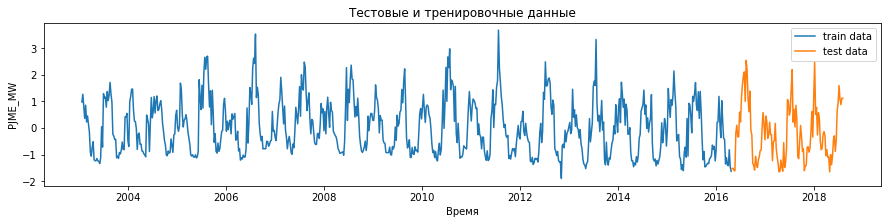

In [504]:
feats_20_case = TSA_model(data=data_pw, target_name='PJME_MW')
feats_20_case.set_timelags(f_steps=1, hist_lags=53)
feats_20_case.set_X_y(scaler_class=StandardScaler)
feats_20_case.select_best_feats(percentile=0.2, show_report=True, final_rule='union', base_model_params={})
feats_20_case.split_data(test_portion=0.2, use_best_feats=True, show_chart=True)

Итого размерность матрицы признаков уменьшена с 80 до 17

**4. Hyperparam Tuning**

In [506]:
param_grid = {
    'n_jobs': [-1],
    'seed': [42],
    'objective': ['reg:squarederror'],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'reg_alpha': [0.5, 0.01, 0],
    'reg_lambda': [0.5, 0.01, 0]
}

feats_20_case.run_grid_search(estimator=XGBRegressor, param_grid_dict=param_grid, cv=7, verbose=True)

best_xgb_params_raw = feats_20_case.best_estimator.get_params()
best_xgb_params = {k:[v] for (k,v) in best_xgb_params_raw.items()}

results on Grid Search for 243 combinations of hyperparams
----------------------------------------------------------------------
lowest avg MSE on cvs: 0.28985077078339, highest: 1.1009482911363642
best params: {'n_jobs': -1, 'seed': 42, 'objective': 'reg:squarederror', 'max_depth': 3, 'learning_rate': 0.1, 'booster': 'gblinear', 'reg_alpha': 0.01, 'reg_lambda': 0.01}
total fit time: 223 sec


Подбор параметров помог уменьшить MSE c 1.1 до 0.29.
Оптимальные параметры записаны в переменную best_xgb_params

**5. Predict generations**

In [516]:
# 1. Simple 1-step forecast object and recursive 4-steps forecast
simple_case = TSA_model(data=data_pw, target_name='PJME_MW')
simple_case.set_timelags(f_steps=1, hist_lags=53)
simple_case.set_X_y(scaler_class=StandardScaler)

simple_case.select_best_feats(percentile=0.2, show_report=False, final_rule='union', 
                                base_model_params={})

simple_case.split_data(test_portion=0.2, use_best_feats=True, show_chart=False)

simple_case.run_grid_search(estimator=XGBRegressor, param_grid_dict=best_xgb_params, cv=7, verbose=False)

simple_case_y_scaled = simple_case.y_test
simple_case_y = simple_case.get_inversed_predict(simple_case_y_scaled)

simple_case_predict_scaled = simple_case.get_test_predict()
simple_case_predict = simple_case.get_inversed_predict(simple_case_predict_scaled)

recurs4_case_predict_scaled = simple_case.get_recursive_prediction(steps=4)
recurs4_case_predict = simple_case.get_inversed_predict(recurs4_case_predict_scaled)

recurs4_case_predict_scaled_full = simple_case.get_recursive_prediction(steps=simple_case.X_test.shape[0]-1)
recurs4_case_predict_full = simple_case.get_inversed_predict(recurs4_case_predict_scaled_full)

simple_case_y_scaled.shape, simple_case_predict_scaled.shape, recurs4_case_predict_scaled.shape

None
None


((119,), (119,), (119,))

In [517]:
# 2. direct 4-step forecast object
direct4_case = TSA_model(data=data_pw, target_name='PJME_MW')
direct4_case.set_timelags(f_steps=4, hist_lags=53)
direct4_case.set_X_y(scaler_class=StandardScaler)

direct4_case.select_best_feats(percentile=0.2, show_report=False, final_rule='union', 
                                base_model_params={})

direct4_case.split_data(test_portion=0.2, use_best_feats=True, show_chart=False)

direct4_case.run_grid_search(estimator=XGBRegressor, param_grid_dict=best_xgb_params, cv=7, verbose=False)

direct4_case_predict_scaled = direct4_case.get_test_predict()
direct4_case_predict = direct4_case.get_inversed_predict(direct4_case_predict_scaled)

direct4_case_predict.shape, direct4_case_predict_scaled.shape

((116,), (116,))

In [515]:
simple_case.X_test.index[3:]

(116,)

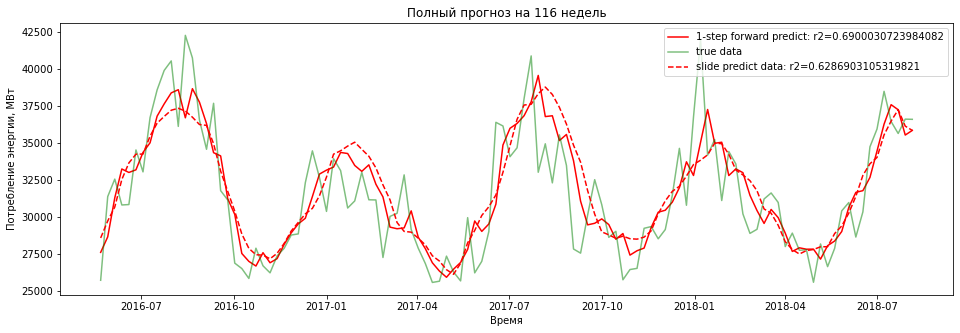

In [521]:
# 3. Визуальное сопоставление
N = 116
time_index = simple_case.X_test.index[3:]
r2_1step = r2_score(simple_case_y[3:], simple_case_predict[3:])
r2_recursive = r2_score(simple_case_y[3:], recurs4_case_predict_full[3:])

plt.figure( figsize=(16, 5))
plt.title(f'Полный прогноз на 116 недель')
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(time_index, simple_case_predict[3:], 'r',label=f'1-step forward predict: r2={r2_1step}' )
plt.plot(time_index, simple_case_y[3:], 'g',label='true data', alpha=0.5)
plt.plot(time_index, recurs4_case_predict_full[3:], '--r',label=f'slide predict data: r2={r2_recursive}')

plt.legend()
plt.show()  

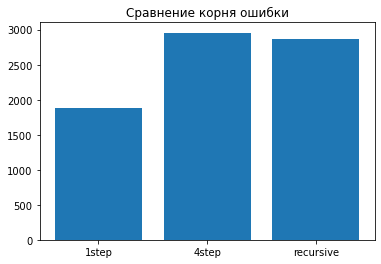

In [522]:
# 4. Итоговое сопоставление: 4-я точка
simple_case_y_adj = simple_case_y[3]
simple_case_predict_adj = simple_case_predict[3]
recurs4_case_predict_adj = recurs4_case_predict[3]
direct4_case_predict_adj = direct4_case_predict[0]

errors = []
for point in [simple_case_predict_adj, direct4_case_predict_adj, recurs4_case_predict_adj]:
    errors.append(np.sqrt((simple_case_y_adj-point)**2))

plt.bar(x=['1step', '4step', 'recursive'], 
        height=errors)
plt.title('Сравнение корня ошибки')
plt.show()


Получилось, что рекурсивный подход работает чуть более аккуратно, нежели прямой вариант

**6. Analytics on forecast period**

None


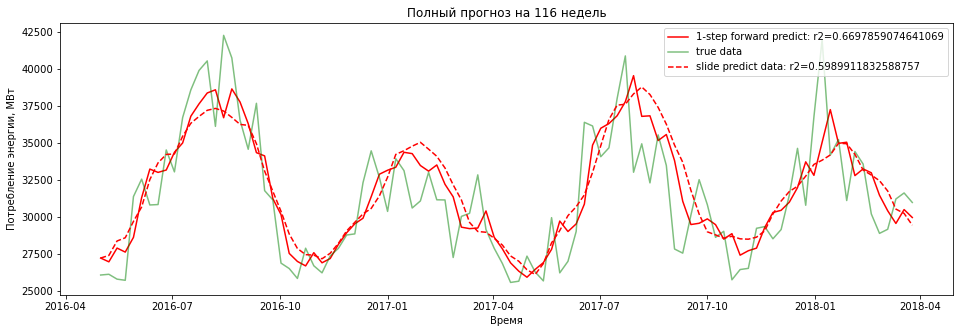

In [532]:
# инициализируем заново модель
model_instance = TSA_model(data=data_pw, target_name='PJME_MW')
model_instance.set_timelags(f_steps=1, hist_lags=53)
model_instance.set_X_y(scaler_class=StandardScaler)

model_instance.select_best_feats(percentile=0.2, show_report=False, final_rule='union', 
                                base_model_params={})

model_instance.split_data(test_portion=0.2, use_best_feats=True, show_chart=False)

model_instance.run_grid_search(estimator=XGBRegressor, param_grid_dict=best_xgb_params, cv=7, verbose=False)

y_test_scaled = simple_case.y_test
y_test = simple_case.get_inversed_predict(simple_case_y_scaled)[:100]

predict_1step_scaled = model_instance.get_test_predict()
predict_1step = model_instance.get_inversed_predict(predict_1step_scaled)[:100]

predict_100step_scaled = model_instance.get_recursive_prediction(steps=100)
predict_100step = model_instance.get_inversed_predict(predict_100step_scaled)[:100]

y_test.shape, predict_1step.shape, predict_100step.shape

time_index = simple_case.X_test.index[:100]
r2_1step = r2_score(y_test, predict_1step)
r2_recursive = r2_score(y_test, predict_100step)

plt.figure( figsize=(16, 5))
plt.title(f'Полный прогноз на 116 недель')
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(time_index, predict_1step, 'r',label=f'1-step forward predict: r2={r2_1step}' )
plt.plot(time_index, y_test, 'g',label='true data', alpha=0.5)
plt.plot(time_index, predict_100step, '--r',label=f'slide predict data: r2={r2_recursive}')

plt.legend()
plt.show() 

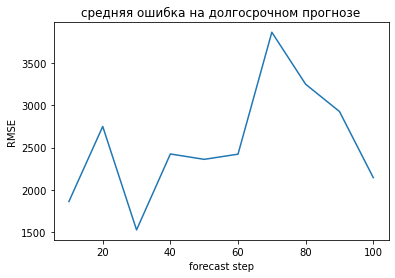

In [546]:
# расчет ошибки
error_list = [y_test[i]-predict_100step[i] for i in range(100)]
grouped_rmse = []

start_idx = 0
for i in range(10,110,10):
    local_error_list = np.array(error_list[start_idx:i+1])
    mse = np.array([j**2 for j in local_error_list]).mean()
    rmse = np.sqrt(mse)
    grouped_rmse.append(rmse)
    start_idx = i

plt.title('средняя ошибка на долгосрочном прогнозе')
plt.plot(range(10,110,10), grouped_rmse)
plt.xlabel('forecast step')
plt.ylabel('RMSE')
plt.show()

В целом ошибка по мере увеличения прогноза возрастает, но не так явно. Возможно это связано со следующими факторами:
- помимо исторических значений целевой переменной, которые в долгосрочных прогнозах заменяются предыдущими прогнозами, на прогноз влияют прочие факторы в X, которые не подвержены искажениям
- в предложенном выше алгоритме долгосрочного прогноза имеется некоторая недоработка, а именно, значения лагов (переменные t и d) - в отличие от исходной переменной-таргет - рекурсивно не обновлялись.
